# Finding use cases for method comparison

... and for figures in paper

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-04-10T12:06:47.039153+02:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



In [2]:
import contextily as cx
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import pandas as pd
import shapely
from shapely.geometry import Point

import core  # noqa: F401
from core import utils

%watermark -w
%watermark -iv

Watermark: 2.5.0

shapely   : 2.0.6
geopandas : 1.0.1
contextily: 1.6.2
matplotlib: 3.9.3
core      : 0.1.dev208+gcab4807.d20250225
momepy    : 0.9.1
pandas    : 2.2.3
folium    : 0.18.0



In [3]:
# which methods to import
methods = [
    "original",
    "cityseer",
    "osmnx",
    "parenx-voronoi",
    "parenx-skeletonize",
    "revised_manual",
    "neatnet",
]

# read in base data
meta = utils.read_sample_data()

In [5]:
?shapely.get_point

Signature: shapely.get_point(geometry, index, **kwargs)
Docstring:
Returns the nth point of a linestring or linearring.

Parameters
----------
geometry : Geometry or array_like
index : int or array_like
    Negative values count from the end of the linestring backwards.
**kwargs
    See :ref:`NumPy ufunc docs <ufuncs.kwargs>` for other keyword arguments.

See also
--------
get_num_points

Examples
--------
>>> from shapely import LinearRing, LineString, MultiPoint, Point
>>> line = LineString([(0, 0), (1, 1), (2, 2), (3, 3)])
>>> get_point(line, 1)
<POINT (1 1)>
>>> get_point(line, -2)
<POINT (2 2)>
>>> get_point(line, [0, 3]).tolist()
[<POINT (0 0)>, <POINT (3 3)>]

The functcion works the same for LinearRing input:

>>> get_point(LinearRing([(0, 0), (1, 1), (2, 2), (0, 0)]), 1)
<POINT (1 1)>

For non-linear geometries it returns None:

>>> get_point(MultiPoint([(0, 0), (1, 1), (2, 2), (3, 3)]), 1) is None
True
>>> get_point(Point(1, 1), 0) is None
True
File:      ~/Library/CloudStora

Read in data

In [9]:
# define city
city = "Douala"
fua = utils.city_fua[city]

geom = meta.loc[meta.eFUA_ID == fua, "geometry"]
city = meta.loc[meta.eFUA_ID == fua, "eFUA_name"].values[0]

gdf_orig = utils.read_original(fua)
proj_crs = gdf_orig.crs

# read in data for each method
geoms = {}
for method in methods:
    gdf = utils.read_results(fua, method, proj_crs)

    # Extract vertices
    _endpoint = lambda x, gdf=gdf: shapely.get_point(  # noqa: E731
        gdf.geometry.explode(ignore_index=True), x
    )

    # _endpoint = get_endpoint(gdf)
    _endpoints = pd.concat([_endpoint(0), _endpoint(-1)]).drop_duplicates()
    vertices = gpd.GeoDataFrame(geometry=_endpoints, crs=gdf.crs)

    geoms[method] = {}
    geoms[method]["lines"] = gdf.copy()
    geoms[method]["vertices"] = vertices.copy()

For one specific use case, ...

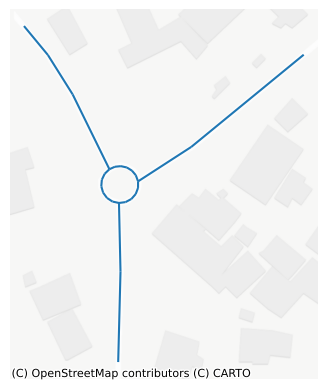

In [10]:
mybuffer = 45
mycoord = [585763.545, 448046.245]
myzoom = Point(mycoord).buffer(mybuffer, cap_style=3)

fig, ax = plt.subplots(1, 1)
geoms["original"]["lines"].clip(myzoom).plot(ax=ax)
ax.set_axis_off()
cx.add_basemap(
    ax=ax, source=cx.providers.CartoDB.Positron, crs=geoms["original"]["lines"].crs
)

Make comparison plot

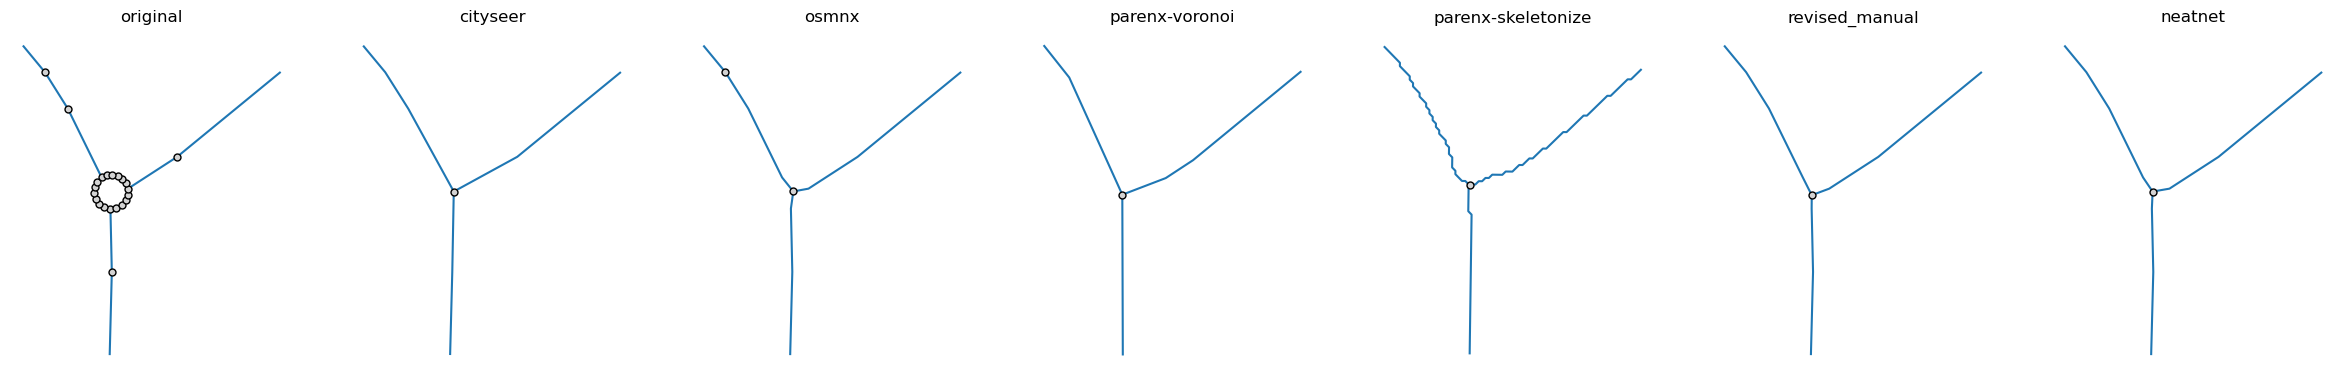

In [11]:
fig, axs = plt.subplots(1, len(methods), figsize=(30, 10))
for ax, method in zip(axs, methods, strict=False):
    lines = geoms[method]["lines"].clip(myzoom).copy()
    vertices = geoms[method]["vertices"].clip(myzoom).copy()
    lines.plot(ax=ax, linewidth=1.5, linestyle="-", zorder=1)
    vertices.plot(ax=ax, facecolor="lightgrey", edgecolor="k", markersize=25, zorder=2)
    ax.set_axis_off()
    ax.set_title(method)

In [12]:
# m = gdfs["cityseer"].explore(name="cityseer", tiles="cartodb.positron", color = "red")
# gdfs["original"].explore(m=m, name="original", color = "black")
# folium.LayerControl().add_to(m)
# m